<a href="https://colab.research.google.com/github/TrSaleMane/deep-learning-from-step-by-step/blob/main/vol06_nn_from_scratch_1/vol06_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vol.6：ニューラルネットを“ゼロから”実装する（前編）


このノートブックでは、ニューラルネットの **順伝播（forward）**と**推論（Predict）** をPyTorch の自動化された機能を使わずに “手書き” で実装します。

####重みとバイアスの初期化

ランダムにパラメータを割り当てます。

In [11]:
import torch

# 入力784 → 隠れ層128
W1 = torch.randn(784, 128) * 0.01
b1 = torch.zeros(128)

# 隠れ層128 → 出力10
W2 = torch.randn(128, 10) * 0.01
b2 = torch.zeros(10)

W1.shape, b1.shape, W2.shape, b2.shape

(torch.Size([784, 128]),
 torch.Size([128]),
 torch.Size([128, 10]),
 torch.Size([10]))

####線形変換（linear）の実装

入力xと重みWの積に、バイアスbを加算します。（重み付き入力信号とバイアスの和）

In [12]:
def linear(x, W, b):
    return x @ W + b

####活性化関数 ReLU の実装

In [13]:
def relu(x):
    return torch.maximum(x, torch.tensor(0.0))

####forward 関数の実装（順伝播）

- 訓練でも推論でも使われる
- ロジット（生の出力）を返す
- 確率やラベルには変換しない


In [14]:
def forward(x):
    # x: [batch, 784]

    # 1層目
    h = linear(x, W1, b1)
    h = relu(h)

    # 2層目（出力）
    out = linear(h, W2, b2)

    return out  # logits

####predict関数の実装（推論）

- 推論（inference）専用
- 確率やラベルを返す
- 学習時には使わない（forward を使う）

In [15]:
def predict(x):
    logits = forward(x)
    preds = torch.argmax(logits, dim=1)
    return preds

 MNIST の1バッチを使って forward（学習） とpredict（推論）を、実行してみます

準備（ライブラリ & データ読み込み）

In [16]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# データ読み込み
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

print("\n")
print("学習データ数：", len(train_dataset))



学習データ数： 60000


forward（学習） とpredict（推論）を実行

In [17]:
# 1バッチ取り出す
images, labels = next(iter(train_loader))

# flatten
x = images.view(64, -1)

# forward
logits = forward(x)

print("入力のshape:", x.shape)
print("出力のshape:", logits.shape)

#predict
y = predict(x)
print("予測ラベル:", y[:10])


入力のshape: torch.Size([64, 784])
出力のshape: torch.Size([64, 10])
予測ラベル: tensor([7, 8, 7, 7, 8, 7, 7, 7, 7, 7])


読み込んだMNISTの画像を表示してみます。

- T = True（正解ラベル）の数字
- P = Pred（モデルの予測）の数字
- 10枚まとめて比較。

下記の10枚の画像データのそれぞれでTとPが一致している場合は、予測が当たっています。（3と6は当たってるなどなど）

ランダムにパラメータを、W1,b1,W2,b2割り当てているだけのニューラルネットワークなのでどうしても正解率は低いです。

**「ランダムな重みだと当たらない」→「学習すると当たるようになる」をいかに実装するか。これが次のステップに重要です。**


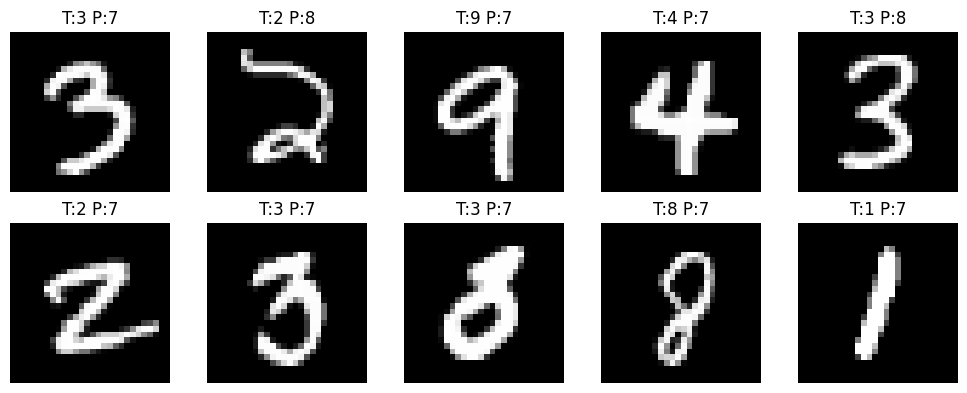

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

for i in range(10):
    plt.subplot(2, 5, i+1)
    img = images[i].squeeze()
    plt.imshow(img, cmap='gray')
    plt.title(f"T:{labels[i].item()} P:{y[i].item()}")
    plt.axis('off')

plt.tight_layout()
plt.show()

出力（logits）を確認

In [19]:
logits[:5]

tensor([[ 0.0075, -0.0056, -0.0001,  0.0004,  0.0031, -0.0169,  0.0026,  0.0085,
          0.0082, -0.0068],
        [-0.0045, -0.0133,  0.0046, -0.0056,  0.0018, -0.0020, -0.0024,  0.0013,
          0.0064, -0.0003],
        [ 0.0023, -0.0122, -0.0076, -0.0051, -0.0099, -0.0144, -0.0092,  0.0049,
          0.0022, -0.0015],
        [ 0.0032, -0.0110, -0.0091, -0.0092, -0.0103, -0.0049, -0.0179,  0.0110,
          0.0018,  0.0024],
        [-0.0008, -0.0062, -0.0139, -0.0068,  0.0006, -0.0049, -0.0006,  0.0045,
          0.0077, -0.0022]])

###完成版のクラス（SimpleNN）作成
ここで、上記の内容をまとめて、完成版のクラスを作っておきます。

ディープラーニングを実装するためには、クラスに必要な機能（forward関数（順伝播）、predict関数（推論）、活性化関数など）をまとめてプログラミングできることが重要です。

SimpleNNクラス

In [20]:
import torch

class SimpleNN:
    def __init__(self, input_dim=784, hidden_dim=128, output_dim=10):
        # 重みとバイアスの初期化
        self.W1 = torch.randn(input_dim, hidden_dim) * 0.01
        self.b1 = torch.zeros(hidden_dim)

        self.W2 = torch.randn(hidden_dim, output_dim) * 0.01
        self.b2 = torch.zeros(output_dim)

    def linear(self, x, W, b):
        return x @ W + b

    def relu(self, x):
        return torch.maximum(x, torch.tensor(0.0))

    def forward(self, x):
        # x: [batch, 784]

        # 1層目
        h = self.linear(x, self.W1, self.b1)
        h = self.relu(h)

        # 2層目（出力）
        out = self.linear(h, self.W2, self.b2)

        return out  # logits

    def predict(self, x):
        logits = self.forward(x)
        preds = torch.argmax(logits, dim=1)
        return preds

MNIST の1バッチで forward を試す。

※クラス（SimpleNN）からインスタンス（model）生成し、実行しています。

準備（ライブラリ & データ読み込み）

In [25]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# データ読み込み
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

print("\n")
print("学習データ数：", len(train_dataset))



学習データ数： 60000


forward（学習） とpredict（推論）を実行

In [26]:
# 1バッチ取り出す
images, labels = next(iter(train_loader))

# flatten
x = images.view(64, -1)

# モデル作成
model = SimpleNN()

# forward
logits = model.forward(x)

print("入力のshape:", x.shape)
print("出力のshape:", logits.shape)

#predict
y = model.predict(x)
print("予測ラベル:", y[:10])


入力のshape: torch.Size([64, 784])
出力のshape: torch.Size([64, 10])
予測ラベル: tensor([5, 5, 5, 5, 5, 5, 5, 1, 5, 0])


このクラス（SimpleNN）で実装したニューラルネットワークについても読み込んだMNISTの画像を表示してみます。

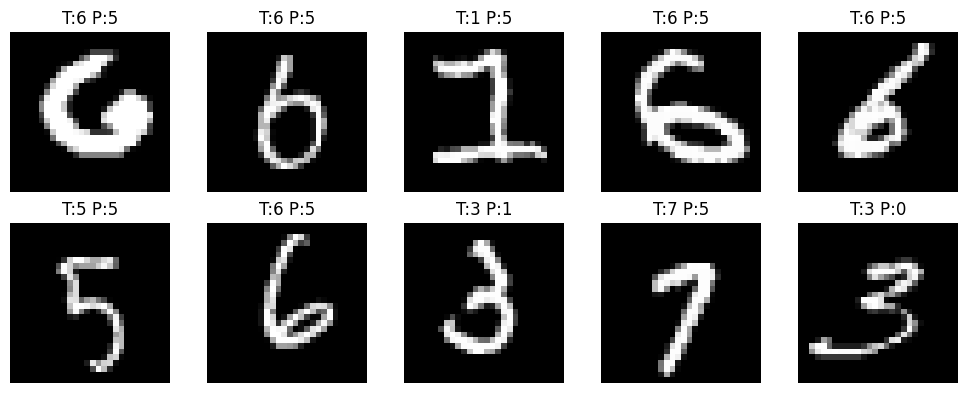

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

for i in range(10):
    plt.subplot(2, 5, i+1)
    img = images[i].squeeze()
    plt.imshow(img, cmap='gray')
    plt.title(f"T:{labels[i].item()} P:{y[i].item()}")
    plt.axis('off')

plt.tight_layout()
plt.show()

出力（logits）を確認

In [23]:
logits[:5]

tensor([[ 0.0095, -0.0089,  0.0031, -0.0136,  0.0031,  0.0080, -0.0021,  0.0135,
         -0.0050,  0.0049],
        [ 0.0014, -0.0019, -0.0021, -0.0017,  0.0035,  0.0059, -0.0018,  0.0029,
          0.0018, -0.0006],
        [ 0.0049, -0.0020, -0.0059, -0.0210, -0.0035,  0.0102, -0.0211,  0.0120,
          0.0021, -0.0147],
        [ 0.0063, -0.0116,  0.0060, -0.0139,  0.0096,  0.0063, -0.0056,  0.0078,
          0.0079, -0.0071],
        [-0.0019, -0.0046,  0.0021, -0.0157, -0.0053,  0.0134, -0.0041,  0.0182,
          0.0045,  0.0113]])

## ▶ 次のステップ

Vol.7 では、  
**損失関数・勾配計算・パラメータ更新・1エポック学習**  
を実装していきます。

いよいよ「学習」が始まります。